<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 0
<br>
<b>Deadline:</b> March 20, 2024 (Wednesday) 23:00
</div>

# Exercise 1. Regularization techniques

This is a simple exercise, in which we will try a few methods to prevent overfitting.

## Learning goals:
* Understand various methods to prevent overfitting of neural networks.
* Experience in using regularization methods in pytorch.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import tools

In [16]:
# Select device which you are going to use for training
device = torch.device("cpu")
#device = torch.device('cuda:0')

In [17]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Regression problem
We will look at a regression problem where the task is to estimate a function of one variable
$$y = f(x)$$
using a set of training examples $(x_1, y_1), \ldots, (x_n, y_n)$.

Let us first generate training examples $y_i=\sin(x_i) + n_i$ with $x_i$ drawn from the uniform distribution in $[-0.5, 0.5]$ and noise $n_i$ drawn from the Gaussian distribution.

In [18]:
np.random.seed(1)
n = 80
x = np.random.rand(n, 1)-0.5

def fun(x):
    y = np.cos(2* np.pi * x)
    y += 0.3 * np.random.randn(*x.shape)
    return y

y = fun(x)

# Convert to PyTorch tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()

Let us split the data into training, validation and test sets and plot the training and validation sets. And let us plot the data.

In [19]:
# Split the data into training and test sets
torch.manual_seed(2)
rp = torch.randperm(x.size(0))

n_train = int(x.size(0) * 0.8)
x_train, y_train = x[rp[:n_train]], y[rp[:n_train]]
x_test, y_test = x[rp[n_train:]], y[rp[n_train:]]

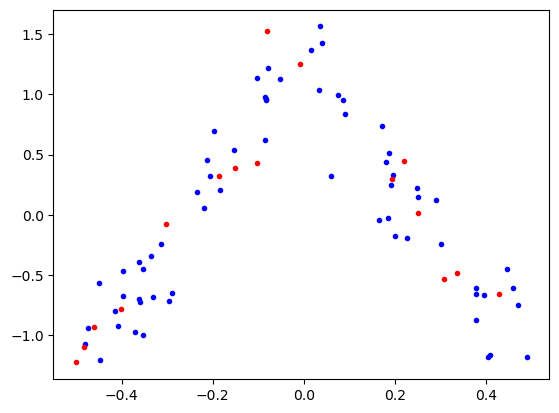

In [20]:
# Plot the data
fix, ax = plt.subplots(1)
ax.plot(x_train, y_train, 'b.')
ax.plot(x_test, y_test, 'r.')

## Define a multi-layer perceptron (MLP) network with two hidden layers

In the code below, we define a neural network architecture with:
* input dimension 1
* one hidden layer with 100 units with tanh nonlinearity
* one hidden layer with 100 units with tanh nonlinearity
* linear output layer with output dimension 1

In [21]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(1,100),
            nn.Tanh(),
            nn.Linear(100,100),
            nn.Tanh(),
            nn.Linear(100,1)
        )

    def forward(self, x):
        return self.block(x)

In [22]:
# Create an MLP network
mlp = MLP()
mlp.to(device)

MLP(
  (block): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [23]:
# Implement the training loop in this cell
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

if torch.cuda.is_available():
    # Storing ID of current CUDA device
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
    print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

    print(device.type)

# Moving all tensors to the GPU
x_train = to_device(x_train, device)
y_train = to_device(y_train, device)
x_test = to_device(x_test, device)
y_test = to_device(y_test, device)

ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2080
cpu


In [24]:
# This visualizes the function implemented by an MLP
def plot_fit(mlp, x_train, y_train):
    fig, ax = plt.subplots(1)
    ax.plot(x_train, y_train, '.')
    x_np = np.linspace(-0.5, 0.5, 100).reshape((-1, 1))
    x = torch.tensor(x_np, device=device, dtype=torch.float)
    pred = mlp.forward(x).cpu().data.numpy()
    ax.plot(x_np, pred)

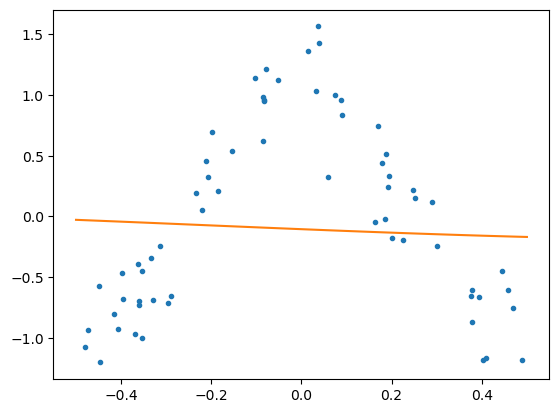

In [25]:
# Plot the function implemented by the MLP
plot_fit(mlp, x_train, y_train)

In [26]:
# This is the function to compute the loss:
def compute_loss(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}'.format(
        epoch, train_error, val_error))

## Train the MLP network without regularization
Training is done by minimizing the mean-squared error computed on the training data:
$$c=\sum_{i=1}^n || f(x_i) - y_i ||^2.$$

Here, we train the network:
* using all the data for computing the gradient (batch mode)
* using `n_epochs` epochs (which is equal to the number of parameter updates in the batch mode).

In [27]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [28]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data
    x = x_train.to(device)
    y = y_train.to(device)
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noreg.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noreg.pth', device)    

Epoch 499: Train error: 0.0554, Test error: 0.0751
Epoch 999: Train error: 0.0472, Test error: 0.0745
Epoch 1499: Train error: 0.0404, Test error: 0.0889
Epoch 1999: Train error: 0.0381, Test error: 0.0971
Epoch 2499: Train error: 0.0276, Test error: 0.1099
Epoch 2999: Train error: 0.0258, Test error: 0.1192
Epoch 3499: Train error: 0.0240, Test error: 0.1195
Epoch 3999: Train error: 0.0210, Test error: 0.1184
Epoch 4499: Train error: 0.0178, Test error: 0.1021
Epoch 4999: Train error: 0.0173, Test error: 0.1062
Epoch 5499: Train error: 0.0178, Test error: 0.1085
Epoch 5999: Train error: 0.0159, Test error: 0.1197
Epoch 6499: Train error: 0.0151, Test error: 0.1306
Epoch 6999: Train error: 0.0143, Test error: 0.1360
Epoch 7499: Train error: 0.0209, Test error: 0.1428
Epoch 7999: Train error: 0.0189, Test error: 0.1666
Epoch 8499: Train error: 0.0135, Test error: 0.1585
Epoch 8999: Train error: 0.0128, Test error: 0.1631
Epoch 9499: Train error: 0.0125, Test error: 0.1639
Epoch 9999: Tr

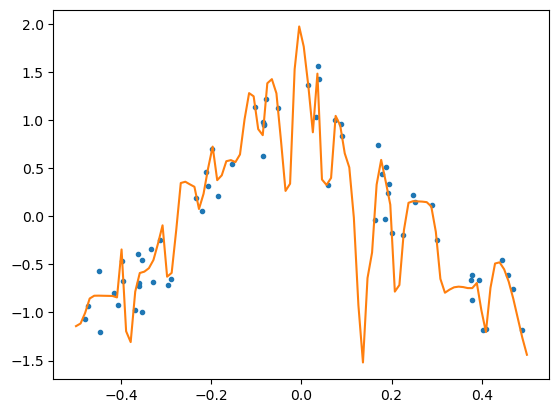

In [29]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

As you can see, the network overfits to the training data.

In [30]:
test_loss_no_regularization = compute_loss(mlp, x_test, y_test)
print("Test loss without regularization: %.5f" % test_loss_no_regularization)

Test loss without regularization: 0.16846


Let us look at the learning curves (the evolution of training and test errors during training).

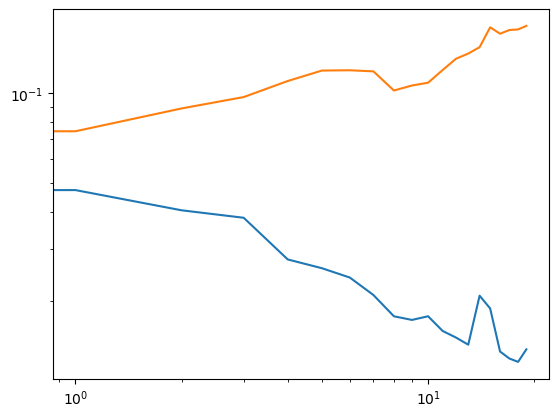

In [31]:
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

 As you can see, the test error first decreases and then starts growing. This motivates the following technique to prevent overfitting.

## Early stopping

In early stopping, we stop training when the test error (or validation error) starts growing.

In the code below, we define a stopping creterion in function `stop_criterion`. Training is stopped (function returns  `True`) when the validation error is larger than the best validation error obtained so far (with given `tolerance`) for `patience` epochs.

In [32]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience
    
    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.
        
        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).
                 
                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

In [33]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [34]:
# Train the network with early stopping
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training error
    val_errors = []  # Keep track of the validation error
    early_stop = EarlyStopping(tolerance=0.01, patience=20)

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))

        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

        if (epoch+1) % 100 == 0:
            print_progress(epoch, train_errors[epoch], val_errors[epoch])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_early.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_early.pth', device)    

Epoch 99: Train error: 0.0830, Test error: 0.0610
Epoch 199: Train error: 0.0667, Test error: 0.0544
Epoch 299: Train error: 0.0661, Test error: 0.0571
Epoch 399: Train error: 0.0660, Test error: 0.0584
Epoch 499: Train error: 0.0659, Test error: 0.0592
Epoch 599: Train error: 0.0658, Test error: 0.0598
Epoch 699: Train error: 0.0657, Test error: 0.0602
Epoch 799: Train error: 0.0655, Test error: 0.0604
Epoch 899: Train error: 0.0653, Test error: 0.0607
Epoch 999: Train error: 0.0650, Test error: 0.0610
Epoch 1099: Train error: 0.0643, Test error: 0.0611
Epoch 1199: Train error: 0.0629, Test error: 0.0614
Epoch 1299: Train error: 0.0610, Test error: 0.0627
0.06339895
Stop after 1330 epochs
Model saved to mlp_early.pth.


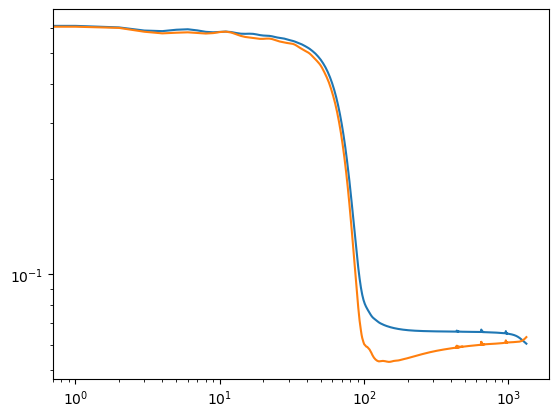

In [35]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

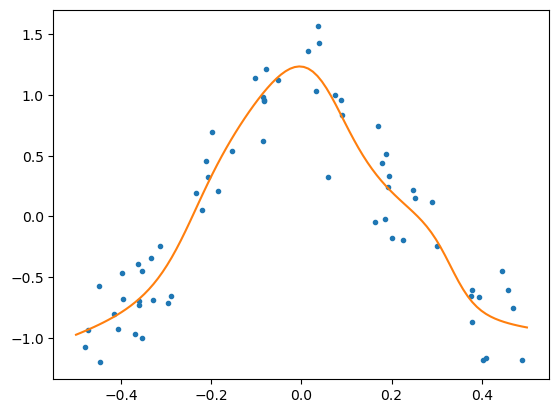

In [36]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [37]:
test_loss_early_stopping = compute_loss(mlp, x_test, y_test)
print("Test loss with early stopping: %.5f" % test_loss_early_stopping)

Test loss with early stopping: 0.06340


## Weight-decay regularization

Let us train the same network with L2 penalties on the weights. In PyTorch, one can add L2 penalty terms for all the parameters by providing `weight_decay` argument for most types of optimizers.

In [38]:
# Train an MLP with L2 regularization
mlp = MLP()
mlp.to(device)
del optimizer

# Create an Adam optimizer with learning rate 0.01 and weight decay parameter 0.001
# optimizer = ...

optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001, weight_decay=0.001)

In [39]:
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_wd.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_wd.pth', device)    

Epoch 99: Train error: 0.1095, Test error: 0.0858
Epoch 199: Train error: 0.0673, Test error: 0.0582
Epoch 299: Train error: 0.0668, Test error: 0.0587
Epoch 399: Train error: 0.0666, Test error: 0.0586
Epoch 499: Train error: 0.0665, Test error: 0.0584
Epoch 599: Train error: 0.0665, Test error: 0.0582
Epoch 699: Train error: 0.0664, Test error: 0.0581
Epoch 799: Train error: 0.0664, Test error: 0.0580
Epoch 899: Train error: 0.0663, Test error: 0.0579
Epoch 999: Train error: 0.0662, Test error: 0.0578
Epoch 1099: Train error: 0.0661, Test error: 0.0578
Epoch 1199: Train error: 0.0660, Test error: 0.0578
Epoch 1299: Train error: 0.0661, Test error: 0.0579
Epoch 1399: Train error: 0.0661, Test error: 0.0581
Epoch 1499: Train error: 0.0661, Test error: 0.0584
Epoch 1599: Train error: 0.0662, Test error: 0.0587
Epoch 1699: Train error: 0.0662, Test error: 0.0586
Epoch 1799: Train error: 0.0662, Test error: 0.0593
Epoch 1899: Train error: 0.0663, Test error: 0.0596
Epoch 1999: Train error

In [40]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)


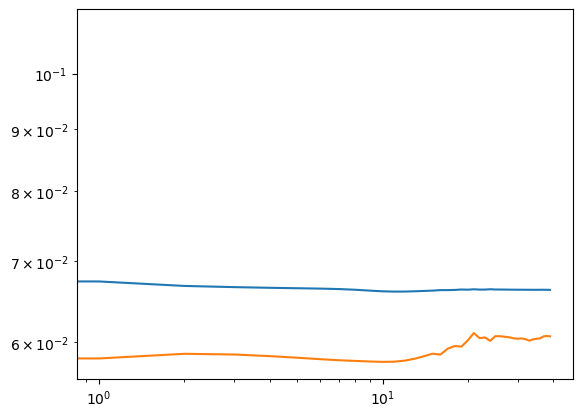

In [41]:
# Plot the learning curves (the evolution of the following quantities during training)
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

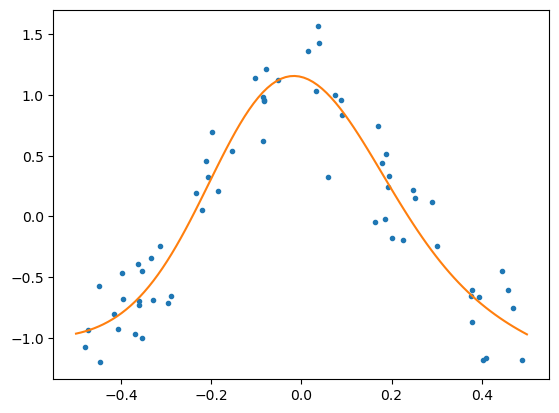

In [42]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [43]:
test_loss_weight_decay = compute_loss(mlp, x_test, y_test)
print("Test loss with weight decay: %.5f" % test_loss_weight_decay)
assert test_loss_weight_decay < 0.11

Test loss with weight decay: 0.06066


## Injecting noise to inputs

One way to improve generalization is to add noise to the inputs. So, we update the parameters of $f$ using the gradient of the following function
$$c= \sum_{i=1}^n || f(x_i + n_i) - y_i ||^2$$
where $n_i$ is a noise instance.

In the code below, implement adding Gaussian noise with standard deviation to the given inputs.

In [44]:
def add_noise(x, noise_std):
    """Add Gaussian noise to a PyTorch tensor.
    
    Args:
      x (tensor): PyTorch tensor of inputs.
      noise_std (float): Standard deviation of the Gaussian noise.
      
    Returns:
      x: Tensor with Gaussian noise added.
    """
    return x + noise_std * torch.randn(x.shape)

In [45]:
# Let's test shapes
x = torch.randn(10)
x_with_noise = add_noise(x, 0.5)
assert x_with_noise.shape == x.shape, f"Bad x_with_noise.shape: {x_with_noise.shape}"

In [46]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [47]:
# Train MLP with injecting noise to inputs
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []
    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(add_noise(x, noise_std=0.05))
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noiseinj.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noiseinj.pth', device)    

Epoch 99: Train error: 0.0710, Test error: 0.0842
Epoch 199: Train error: 0.0900, Test error: 0.0863
Epoch 299: Train error: 0.0728, Test error: 0.0866
Epoch 399: Train error: 0.0701, Test error: 0.0714
Epoch 499: Train error: 0.0708, Test error: 0.0868
Epoch 599: Train error: 0.0708, Test error: 0.0772
Epoch 699: Train error: 0.0661, Test error: 0.0805
Epoch 799: Train error: 0.0620, Test error: 0.0771
Epoch 899: Train error: 0.0635, Test error: 0.0784
Epoch 999: Train error: 0.0638, Test error: 0.0764
Epoch 1099: Train error: 0.0682, Test error: 0.0837
Epoch 1199: Train error: 0.0661, Test error: 0.0808
Epoch 1299: Train error: 0.0668, Test error: 0.0793
Epoch 1399: Train error: 0.0650, Test error: 0.0846
Epoch 1499: Train error: 0.0652, Test error: 0.0824
Epoch 1599: Train error: 0.0645, Test error: 0.0773
Epoch 1699: Train error: 0.0674, Test error: 0.0726
Epoch 1799: Train error: 0.0639, Test error: 0.0757
Epoch 1899: Train error: 0.0628, Test error: 0.0787
Epoch 1999: Train error

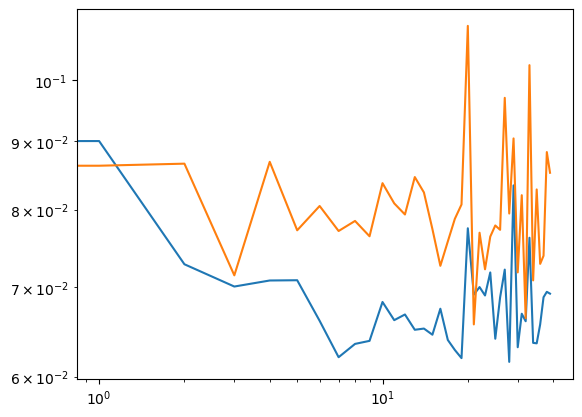

In [48]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

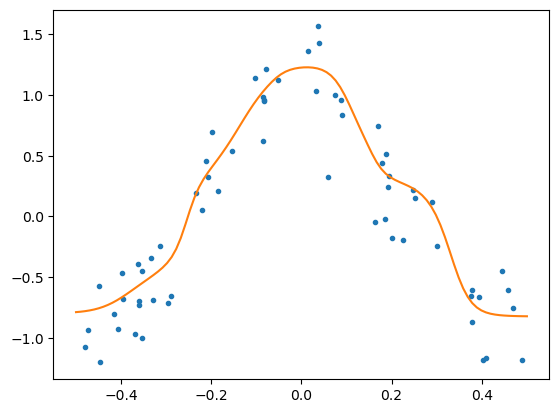

In [49]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [50]:
# Let's look at the test loss
test_loss_inj_noise = compute_loss(mlp, x_test, y_test)
print("Test loss with noise injection: %.5f" % test_loss_inj_noise)
assert test_loss_inj_noise < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with noise injection: 0.08522


## Dropout

Another way to improve generalization is to use dropout. In the cell below, define an MLP with exactly the same architecture as previously but with using `nn.Dropout` layers (with dropout probability 0.2) after each `tanh`
nonlinearity. 

In [53]:
class MLPDropout(nn.Module):
    def __init__(self):
        super(MLPDropout, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(1,100),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(100,100),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(100,1)
        )
        
    def forward(self, x):
        return self.block(x)

In [54]:
mlp = MLPDropout()
print(mlp)

MLPDropout(
  (block): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [55]:
mlp = MLPDropout()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [56]:
# Train MLP with dropout
if not skip_training:
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        #scheduler.step()
        mlp.train()
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            mlp.eval()
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_dropout.pth', confirm=False)
else:
    mlp = MLPDropout()
    tools.load_model(mlp, 'mlp_dropout.pth', device)    

Epoch 99: Train error: 0.0791, Test error: 0.0830
Epoch 199: Train error: 0.0707, Test error: 0.0792
Epoch 299: Train error: 0.0730, Test error: 0.0967
Epoch 399: Train error: 0.0654, Test error: 0.0813
Epoch 499: Train error: 0.0699, Test error: 0.0794
Epoch 599: Train error: 0.0647, Test error: 0.0843
Epoch 699: Train error: 0.0699, Test error: 0.0813
Epoch 799: Train error: 0.0640, Test error: 0.0804
Epoch 899: Train error: 0.0644, Test error: 0.0843
Epoch 999: Train error: 0.0728, Test error: 0.0795
Epoch 1099: Train error: 0.0639, Test error: 0.0832
Epoch 1199: Train error: 0.0674, Test error: 0.0852
Epoch 1299: Train error: 0.0679, Test error: 0.0746
Epoch 1399: Train error: 0.0720, Test error: 0.0827
Epoch 1499: Train error: 0.0655, Test error: 0.0735
Epoch 1599: Train error: 0.0641, Test error: 0.0828
Epoch 1699: Train error: 0.0622, Test error: 0.0797
Epoch 1799: Train error: 0.0664, Test error: 0.0966
Epoch 1899: Train error: 0.0683, Test error: 0.0724
Epoch 1999: Train error

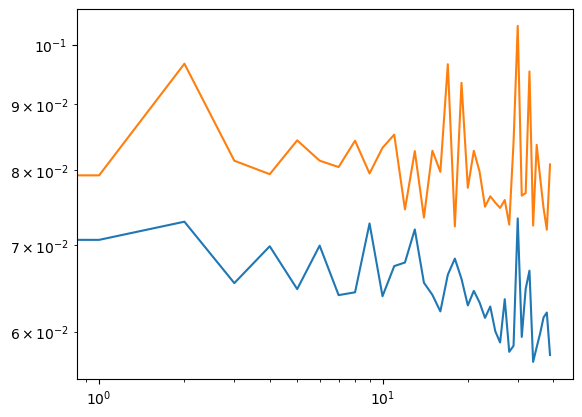

In [57]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

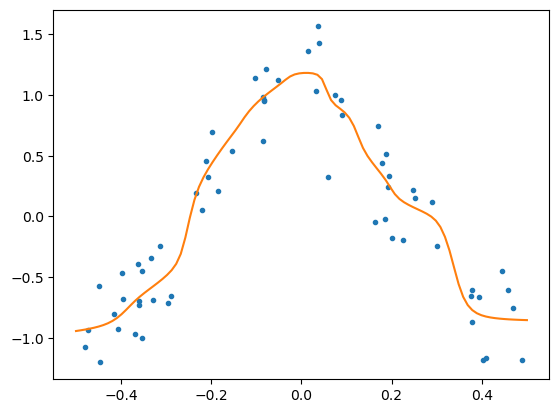

In [58]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [59]:
# Let's look at the test loss
test_loss_dropout = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_dropout)
assert test_loss_dropout < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with dropout: 0.08080


## Reducing model capacity

Another simple way to reduce overfitting is to reduce the capacity of the model. Let us use for the same regression task a much smaller network: an MLP with one hidden layer with five units, tanh nonlinearity in the hidden layer and a linear output layer.

In [60]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(1,5),
            nn.Tanh(),
            nn.Linear(5,1)
        )
    
    def forward(self, x):
        return self.block(x)

In [61]:
mlp = MLPSmall()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [62]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_small.pth', confirm=False)
else:
    mlp = MLPSmall()
    tools.load_model(mlp, 'mlp_small.pth', device)    

Epoch 499: Train error: 0.5823, Test error: 0.5686
Epoch 999: Train error: 0.4815, Test error: 0.4542
Epoch 1499: Train error: 0.1473, Test error: 0.1194
Epoch 1999: Train error: 0.1019, Test error: 0.0760
Epoch 2499: Train error: 0.0906, Test error: 0.0676
Epoch 2999: Train error: 0.0827, Test error: 0.0617
Epoch 3499: Train error: 0.0769, Test error: 0.0573
Epoch 3999: Train error: 0.0724, Test error: 0.0542
Epoch 4499: Train error: 0.0698, Test error: 0.0529
Epoch 4999: Train error: 0.0686, Test error: 0.0529
Epoch 5499: Train error: 0.0679, Test error: 0.0534
Epoch 5999: Train error: 0.0673, Test error: 0.0542
Epoch 6499: Train error: 0.0668, Test error: 0.0553
Epoch 6999: Train error: 0.0664, Test error: 0.0566
Epoch 7499: Train error: 0.0662, Test error: 0.0580
Epoch 7999: Train error: 0.0661, Test error: 0.0592
Epoch 8499: Train error: 0.0660, Test error: 0.0599
Epoch 8999: Train error: 0.0660, Test error: 0.0603
Epoch 9499: Train error: 0.0660, Test error: 0.0603
Epoch 9999: Tr

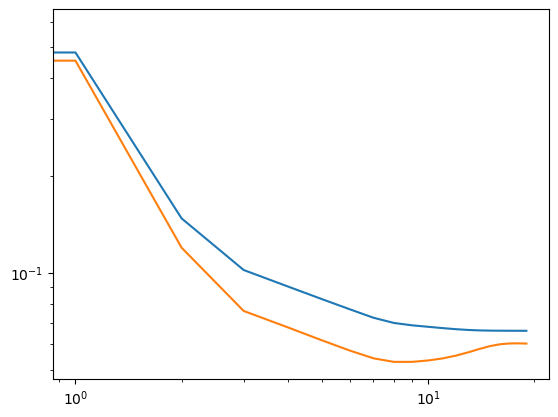

In [63]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

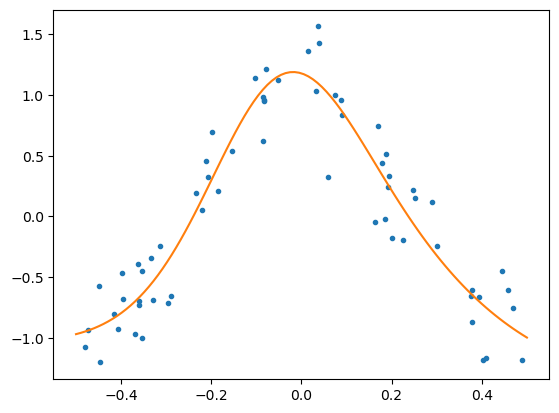

In [64]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [65]:
# Let's look at the test loss
test_loss_small = compute_loss(mlp, x_test, y_test)
print("Test loss by reducing model capacity: %.5f" % test_loss_small)
assert test_loss_small < 0.11
assert optimizer.defaults['weight_decay'] == 0

Test loss by reducing model capacity: 0.06024


In [66]:
# We can summarize the results obtained with different regularization methods:
print('No regularization: %.5f' % test_loss_no_regularization)
print('Early stopping:    %.5f' % test_loss_early_stopping)
print('Weight decay:      %.5f' % test_loss_weight_decay)
print('Noise injection:   %.5f' % test_loss_inj_noise)
print('Dropout:           %.5f' % test_loss_dropout)
print('Small network:     %.5f' % test_loss_small)

No regularization: 0.16846
Early stopping:    0.06340
Weight decay:      0.06066
Noise injection:   0.08522
Dropout:           0.08080
Small network:     0.06024


The values of the hyperparameters (parameters of the training procedure) may have major impact on the results. One has to find the best hyperparameter values which is usually done by measuring the performance on the validation set.